In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

from utils.roc_auc import plot_roc_curve
from utils.model_comparison import run_model_iterations, compare_model_statistics

In [13]:
target_column = 'TARGET' 

In [14]:
data = pd.read_csv("./data/processed_data/processed_application_train_with_features.csv", index_col=0)
data.columns = data.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

In [35]:
# Определение целевой переменной и признаков
target_column = 'TARGET'  # Замените на имя вашей целевой переменной
X = data.drop(columns=[target_column])
y = data[target_column]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

imputer = SimpleImputer(strategy='most_frequent')  # Вы можете использовать 'median' или 'most_frequent'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['SK_ID_BUREAU' 'MONTHS_BALANCE_COUNT' 'BUREAU_BALANCE_POSITIVE_STATUS'
 'BUREAU_BALANCE_LATE_STATUS']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['SK_ID_BUREAU' 'MONTHS_BALANCE_COUNT' 'BUREAU_BALANCE_POSITIVE_STATUS'
 'BUREAU_BALANCE_LATE_STATUS']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [16]:
data.shape

(307511, 269)

Для продакшн-версии мы будем использовать модель, которая продемонстрировала наилучшие результаты в ходе тестирования. Однако для удобства пользователей мы отберем только самые важные признаки, чтобы избежать необходимости вводить большое количество признаков в пользовательском интерфейсе.

In [ ]:
%store -r xgb_best_params

xgb_best_params["scale_pos_weight"] = len(y_train) / (2 * np.bincount(y_train)[1]) # пересчитаем доли если разбиения данных не совпадают
xgb_best_params["eval_metric"] = 'logloss' 

Исследуем зависимость снижения целевая метрика при уменьшении количества используемых признаков

/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [251 254] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [251 254] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [251 2

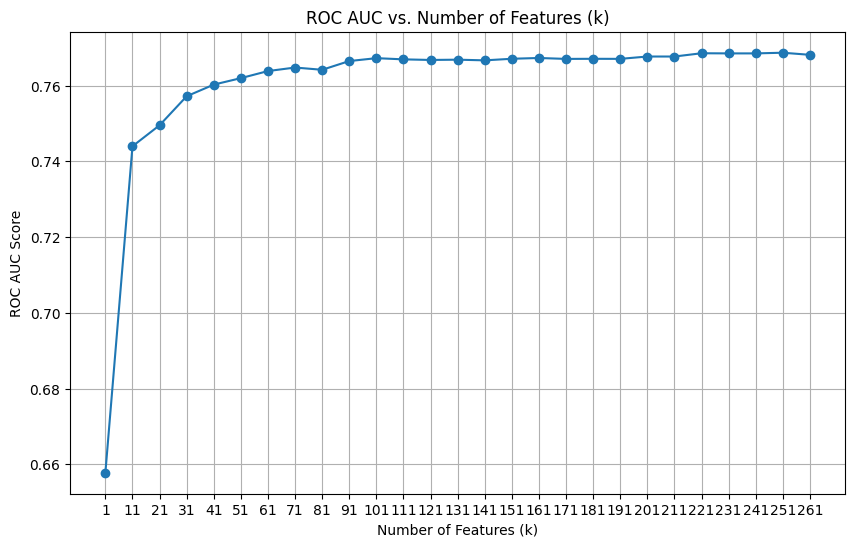

In [21]:
# Список для хранения значений ROC AUC
roc_auc_scores = []
k_values = range(1, X_train.shape[1], 10)

for k in k_values:
    # Отбор K лучших признаков
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Обучение модели на отобранных признаках
    xgb_model_selected = XGBClassifier(**xgb_best_params)
    xgb_model_selected.fit(X_train_selected, y_train)

    # Оценка модели
    y_pred_proba_selected = xgb_model_selected.predict_proba(X_test_selected)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba_selected)
    roc_auc_scores.append(roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_values, roc_auc_scores, marker='o')
plt.title('ROC AUC vs. Number of Features (k)')
plt.xlabel('Number of Features (k)')
plt.ylabel('ROC AUC Score')
plt.xticks(k_values)
plt.grid()
plt.show()

При анализе зависимости ROC AUC от количества отобранных признаков было замечено, что при использовании 11 признаков метрика не падает значительно по сравнению с использованием большего количества признаков. Это позволяет нам сделать вывод, что 11 признаков достаточно для достижения хорошей производительности модели, и мы можем использовать именно это количество для дальнейшего обучения.

Также для прода есть смысл откалибровать предсказания модели, сделаем это через сигмоидальным метод

In [ ]:
# Отбор 11 лучших признаков
k_best = 11
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Обучение модели на отобранных признаках
xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(X_train_selected, y_train)

# Калибровка вероятностей
calibrated_model = CalibratedClassifierCV(estimator=xgb_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_selected, y_train)

/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [251 254] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=3,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

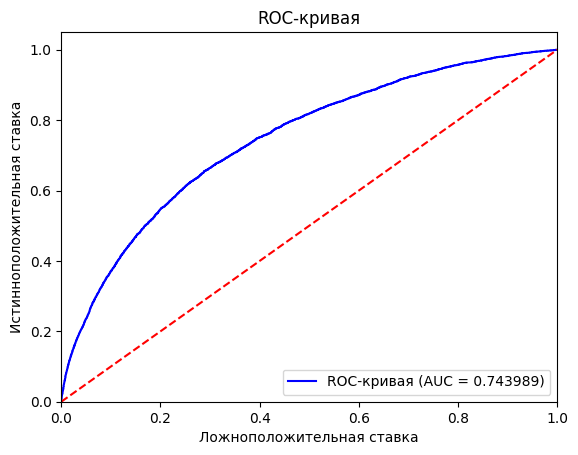

ROC AUC: 0.743989


In [29]:
# Прогнозирование на тестовой выборке с использованием отобранных признаков
y_pred_proba = calibrated_model.predict_proba(X_test_selected)[:, 1] 

# Вычисляем ROC-кривую и AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC-кривая (AUC = {:.6f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного выбора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная ставка')
plt.ylabel('Истинноположительная ставка')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

print(f'ROC AUC: {roc_auc:.6f}')


Сохранение откалиброванной модели

In [31]:
import joblib
joblib.dump(calibrated_model, 'models/calibrated_xgb_model.pkl')

['models/calibrated_xgb_model.pkl']

In [ ]:
selected_indices = selector.get_support(indices=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
selected_features = X_train.columns[selected_indices]
selected_features

Index(['DAYS_BIRTH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher_education', 'BUREAU_DAYS_CREDIT_MEAN',
       'BUREAU_DAYS_CREDIT_MIN', 'CREDIT_CARD_POSITIVE_STATUS',
       'INSTALLMENTS_TOTAL_PAYMENT'],
      dtype='object')

In [44]:
X_train[selected_features].dtypes

DAYS_BIRTH                                int64
REGION_RATING_CLIENT                      int64
REGION_RATING_CLIENT_W_CITY               int64
EXT_SOURCE_1                            float64
EXT_SOURCE_2                            float64
EXT_SOURCE_3                            float64
NAME_EDUCATION_TYPE_Higher_education       bool
BUREAU_DAYS_CREDIT_MEAN                 float64
BUREAU_DAYS_CREDIT_MIN                  float64
CREDIT_CARD_POSITIVE_STATUS             float64
INSTALLMENTS_TOTAL_PAYMENT              float64
dtype: object